In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import gensim
import spacy
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Embedding, Conv1D, LSTM, Bidirectional

In [2]:
print(tf. __version__)

2.10.0


### **Plan of Action**

- Load the data
- Drop unnecessary columns and rows
- Removal of stop words.
- Feature engineering;
    - Glove-twitter-200
- Begin modelling
    - Algorithms to use;
        - BiLSTM

In [3]:
df_clean = pd.read_csv('../data/cleaned_reviews.csv')

In [4]:
df_clean.shape

(17340, 4)

In [5]:
df_clean.columns

Index(['sentiments', 'cleaned_review', 'cleaned_review_length',
       'review_score'],
      dtype='object')

In [6]:
df_clean.drop(columns=['cleaned_review_length','review_score'],inplace=True)

**Checking for Null Vaules and Duplicates**

In [7]:
df_clean.isna().sum()

sentiments        0
cleaned_review    3
dtype: int64

In [8]:
df_clean.dropna(inplace=True)

In [9]:
df_clean.shape

(17337, 2)

In [10]:
from spacy.lang.en.stop_words import STOP_WORDS

all_stopwords = STOP_WORDS

# Removing several stop words
all_stopwords-= {'not',"no", "n't", 'n’t','n‘t','cannot','none','without','against','off','against','too'}
my_stop_words = set(all_stopwords) # My own stop words

In [11]:
df_clean

,sentiments,cleaned_review
0,positive,i wish would have gotten one earlier love it a...
1,neutral,i ve learned this lesson again open the packag...
2,neutral,it is so slow and lags find better option
3,neutral,roller ball stopped working within months of m...
4,neutral,i like the color and size but it few days out ...
...,...,...
17335,positive,i love this speaker and love can take it anywh...
17336,positive,i use it in my house easy to connect and loud ...
17337,positive,the bass is good and the battery is amazing mu...
17338,positive,love it


In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def spacy_tokeniser(sent):
    sent = sent.strip().lower()
    doc = nlp(sent)
    mytokens = [token.lemma_ for token in doc if token.text not in my_stop_words]
    return mytokens

In [14]:
df_clean['tokens']= df_clean['cleaned_review'].apply(spacy_tokeniser)

In [15]:
df_clean.head()

,sentiments,cleaned_review,tokens
0,positive,i wish would have gotten one earlier love it a...,"[wish, get, early, love, make, work, laptop, e..."
1,neutral,i ve learned this lesson again open the packag...,"[ve, learn, lesson, open, package, use, produc..."
2,neutral,it is so slow and lags find better option,"[slow, lag, find, well, option]"
3,neutral,roller ball stopped working within months of m...,"[roller, ball, stop, work, month, minimal, use..."
4,neutral,i like the color and size but it few days out ...,"[like, color, size, day, return, period, not, ..."


In [16]:
# Dropping unnecessary columns
df_clean.drop(columns=['cleaned_review'],inplace=True)

**Sentiment Mapping**

In [17]:
# Mapping was changed due to the use of a neural network architecture
sentiment_mapping = {'negative':0,'neutral':1,'positive':2} 
df_clean['sentiment_label'] = df_clean.sentiments.map(sentiment_mapping)

In [18]:
df_clean.drop(columns=['sentiments'],inplace=True)

**Text Sequencing**

Now we tokenize the sentences and convert X into sequences of numbers:
- Embedding layer expects the words to be in numeric form 
- Using Tokenizer function from keras.preprocessing.text library
- Method fit_on_text trains the tokenizer 
- Method texts_to_sequences converts sentences to their numeric form

In [19]:
X = df_clean["tokens"]

In [20]:
X[0]

['wish', 'get', 'early', 'love', 'make', 'work', 'laptop', 'easy']

In [21]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X)

X = word_tokenizer.texts_to_sequences(X)
X[0]

[153, 26, 758, 9, 124, 1, 51, 34]

In [22]:
review_max_length = 0
for i in df_clean['tokens']: 
    length = len(i)
    if length > review_max_length:
        review_max_length = length

print(review_max_length) 

293


In [23]:
len(word_tokenizer.word_index)

7258

In [24]:
vocab = word_tokenizer.word_index.items()

In [25]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

7259

In [26]:
max_len = 300
X = pad_sequences(X,padding="post",maxlen=max_len)

In [27]:
X[1].shape # shape
X[1].ndim # dimension

1

### **Creating Embedding Matrix**

In [28]:
import pickle
# Loading saved word2vec glove_twitter_25.pkl
vectorizer = pickle.load(open('../../../../word2vec_files/glove_twitter_200.pkl', "rb"))

In [29]:
len(vectorizer.key_to_index.keys()) 

1193514

In [30]:
# Create Embedding Matrix having 200 columns 
# Containing 200-dimensional GloVe word embeddings for all words in our corpus

w2v_vector_size = vectorizer.vector_size
embedding_matrix = np.zeros((vocab_length, w2v_vector_size)) 
# print(embedding_matrix.shape) # (7259, 200)
# print(embedding_matrix.ndim) # 2-dimensional array

In [31]:
for word, index in vocab:
    if word in vectorizer.key_to_index.keys():
        embedding_matrix[index] = vectorizer[word]
    else:
        embedding_matrix[index] = np.zeros(w2v_vector_size)

In [32]:
# embedding_matrix.shape # (7259, 200)
# embedding_matrix.ndim # 2-dimensional array

### **Model Building**

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# y_nn = tf.keras.utils.to_categorical(df_clean['sentiment_label'], num_classes=3, dtype='int8')
y_nn = tf.keras.utils.to_categorical(df_clean.sentiment_label.values, num_classes=3, dtype='int8')

In [35]:
X_train, X_test, y_train,y_test= train_test_split(
                                            X,y_nn,test_size=.2,random_state=42, 
                                            stratify=y_nn)
# The train set will be used to train our deep learning models 
# while test set will be used to evaluate how well our model performs 

#### **Subclassing Approaches**

Basic Subclassing; Same as both sequential & Functional approaches

In [36]:
from tensorflow.keras.layers import Input,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [37]:
class MyModel(tf.keras.Model):
    def __init__(self,num_classes,embedding_matrix):
        super(MyModel, self).__init__()
        # Creating the layer instance attributes
        self.embedding = Embedding(vocab_length,w2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)
        self.hidden1 = Bidirectional(LSTM(128,return_sequences=True),name="hidden1")
        self.hidden2 = Bidirectional(LSTM(128),name="hidden2")
        self.classifier = Dense(num_classes, activation="softmax")

    def call(self,input_tensor,training=False):
        embedding_layer = self.embedding(input_tensor)
        x = self.hidden1(embedding_layer)
        x = self.hidden2(x)
        x = self.classifier(x)
        return x

    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=(raw_shape), 
                                         ragged=True)
        return tf.keras.Model(inputs=[x], 
                              outputs=self.call(x))

In [38]:
input_layer = tf.keras.layers.Input(shape=(300), name="supply")
model = MyModel(3,embedding_matrix)

In [39]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
# model.build(input_layer.shape)
model.build_graph(300).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 200)          1451800   
                                                                 
 hidden1 (Bidirectional)     (None, 300, 256)          336896    
                                                                 
 hidden2 (Bidirectional)     (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 2,183,707
Trainable params: 731,907
Non-trainable params: 1,451,800
_________________________________________________________________


In [40]:
# How Training and Evaluation is done for this method

# bi_lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# # Model training
# bi_lstm_model_history = bi_lstm_model.fit(
#     X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
# )

# # Evaluations on the Test Set
# score = bi_lstm_model.evaluate(X_test, y_test, verbose=1)

Wide and Deep Neural network

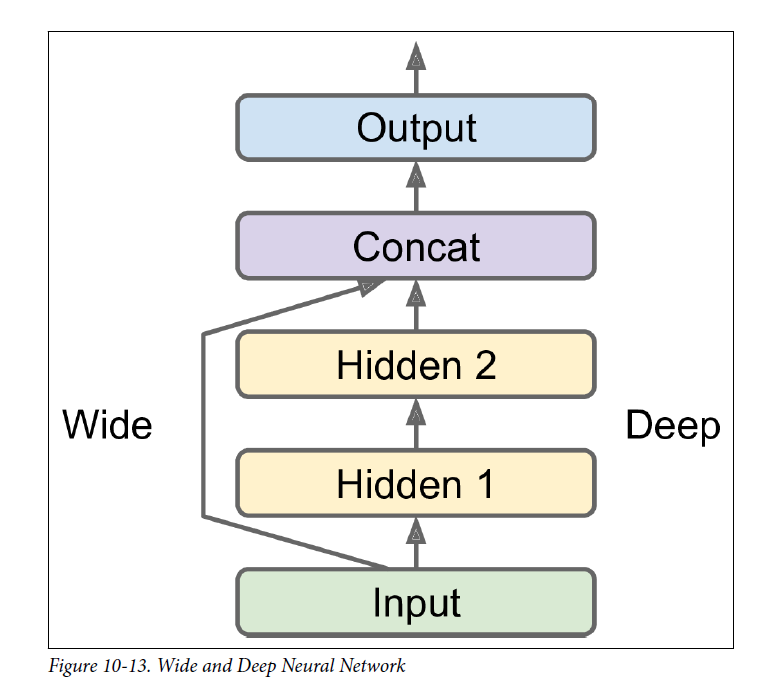

In [41]:
from PIL import Image
img =Image.open("../img/WideandDeepNeuralNetwork.png")
img

# Refer to page 305 of Hands-on Machine Learning with Scikit-Learn, Keras, 
# and TensorFlow Concepts, Tools, 
# and Techniques to Build Intelligent Systems by Aurélien Géron 
# June 2019: Second Edition

In [42]:
class MyModel(tf.keras.Model):
    def __init__(self,num_classes,embedding_matrix):
        super(MyModel, self).__init__()
        # Creating the layer instance attributes
        self.embedding = Embedding(vocab_length,w2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)
        self.hidden1 = Bidirectional(LSTM(128,return_sequences=True),name="hidden1")
        self.hidden2 = Bidirectional(LSTM(128),name="hidden2")
        self.concat = tf.keras.layers.Concatenate()
        self.classifier = Dense(num_classes, activation="softmax")

    def call(self,input_tensor,training=False):
        embedding_layer = self.embedding(input_tensor)
        x = self.hidden1(embedding_layer)
        x = self.hidden2(x)
        x = self.concat([input_tensor,x])
        x = self.classifier(x)
        return x

    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=(raw_shape), 
                                         ragged=True)
        return tf.keras.Model(inputs=[x], 
                              outputs=self.call(x))

In [43]:
input_layer = tf.keras.layers.Input(shape=(300), name="supply")
model = MyModel(3,embedding_matrix)

In [44]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
# model.build(input_layer.shape)
model.build_graph(300).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 300, 200)     1451800     ['input_2[0][0]']                
                                                                                                  
 hidden1 (Bidirectional)        (None, 300, 256)     336896      ['embedding_1[0][0]']            
                                                                                                  
 hidden2 (Bidirectional)        (None, 256)          394240      ['hidden1[0][0]']                
                                                                                            

In [45]:
# How Training and Evaluation is done for this method

# bi_lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# # Model training
# bi_lstm_model_history = bi_lstm_model.fit(
#     X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
# )

# # Evaluations on the Test Set
# score = bi_lstm_model.evaluate(X_test, y_test, verbose=1)

Residual Block

In [46]:
from tensorflow.keras.layers import Add

In [47]:
class MyModel(tf.keras.layers.Layer):
    def __init__(self,embedding_matrix):
        super(MyModel, self).__init__()
        # Creating the layer instance attributes
        self.embedding = Embedding(vocab_length,w2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)
        self.hidden1 = LSTM(128,return_sequences=True,name="hidden1")


    def call(self,input_tensor,training=False):
        embedding_layer = self.embedding(input_tensor)
        x = self.hidden1(embedding_layer)
        return x

    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=(raw_shape), 
                                         ragged=True)

        return tf.keras.Model(inputs=[x], 
                              outputs=self.call(x))

In [48]:
class Residual(tf.keras.layers.Layer):
    def __init__(self):
        super(Residual, self).__init__()
        # Creating the layer instance attributes
        # residual_blocks
        self.residual_block1 = Bidirectional(LSTM(128,return_sequences=True), name="identity_block_hidden1") # 128 + 128 = 256
        self.residual_block2 = Bidirectional(LSTM(64,return_sequences=True), name="identity_block_hidden2") # 64 + 64 = 128
        self.add_layer = tf.keras.layers.Add()
        
        

    def call(self,input_tensor,training=False):
        identity = input_tensor
        x = self.residual_block1(input_tensor)
        x = self.residual_block2(x)
        added = self.add_layer([identity,x])
        return added

    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=(raw_shape), 
                                         ragged=True)

        return tf.keras.Model(inputs=[x], 
                              outputs=self.call(x))

In [49]:
class MyModelClassifier(tf.keras.Model):
# class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModelClassifier, self).__init__()
        # Creating the layer instance attributes
        self.outer_layer = MyModel(embedding_matrix)
        self.residual = Residual()
        self.hidden3 = LSTM(32,name="hidden3")
        self.classifier = Dense(3, activation="softmax")

    def call(self,input_tensor,training=False):
        x = self.outer_layer(input_tensor) 
        x = self.residual(x)
        x = self.hidden3(x)
        x = self.classifier(x)

        return x

    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=(raw_shape), 
                                         ragged=True)

        return tf.keras.Model(inputs=[x], 
                              outputs=self.call(x))

In [50]:
input_layer = tf.keras.layers.Input(shape=300, name="supply")
model = MyModelClassifier()

In [51]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
# model.build(input_layer.shape)
model.build_graph(300).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 my_model_2 (MyModel)        (None, 300, 128)          1620248   
                                                                 
 residual (Residual)         (None, 300, 128)          427520    
                                                                 
 hidden3 (LSTM)              (None, 32)                20608     
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,068,475
Trainable params: 616,675
Non-trainable params: 1,451,800
_________________________________________________________________


In [52]:
# How Training and Evaluation is done for this method

# bi_lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# # Model training
# bi_lstm_model_history = bi_lstm_model.fit(
#     X_train,y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
# )

# # Evaluations on the Test Set
# score = bi_lstm_model.evaluate(X_test, y_test, verbose=1)

In [53]:
X_train_A, X_train_B = X_train[:, :100], X_train[:, 100:]
X_test_A, X_test_B = X_test[:, :100], X_test[:, 100:]
print(" Train: {}".format(X_train.shape))
print(" Train_A: {}".format(X_train_A.shape))
print(" Train_B: {}".format(X_train_B.shape))
print(" Test: {}".format(X_test.shape))
print(" Test_A: {}".format(X_test_A.shape))
print(" Test_B: {}".format(X_test_B.shape))

 Train: (13869, 300)
 Train_A: (13869, 100)
 Train_B: (13869, 200)
 Test: (3468, 300)
 Test_A: (3468, 100)
 Test_B: (3468, 200)


Handling Multiple Inputs

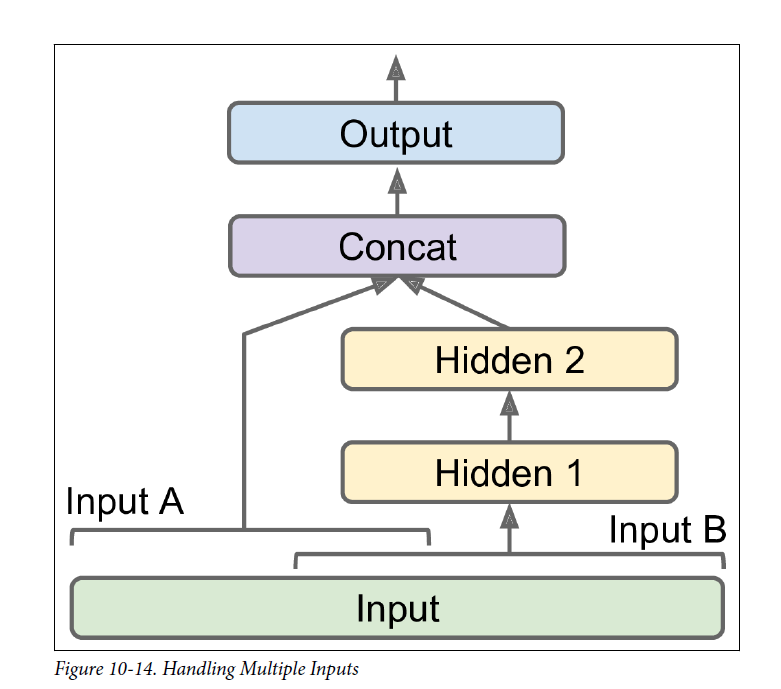

In [54]:
from PIL import Image
img =Image.open("../img/HandlingMultipleInputs.png")
img

# Refer to page 307 of Hands-on Machine Learning with Scikit-Learn, Keras, 
# and TensorFlow Concepts, Tools, 
# and Techniques to Build Intelligent Systems by Aurélien Géron 
# June 2019: Second Edition

In [55]:
class MyModel(tf.keras.layers.Layer):
# class MyModel(tf.keras.Model):
    def __init__(self,embedding_matrix):
        super(MyModel, self).__init__()
        # Creating the layer instance attributes
        self.embedding = Embedding(vocab_length,w2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)
        self.hidden1 = Bidirectional(LSTM(128,return_sequences=True),name="hidden1")
        self.hidden2 = Bidirectional(LSTM(128),name="hidden2")
        


    def call(self,input_tensor,training=False):
        embedding_layer = self.embedding(input_tensor)
        x = self.hidden1(embedding_layer)
        x = self.hidden2(x)
        return x

    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=(raw_shape), 
                                         ragged=True)

        return tf.keras.Model(inputs=[x], 
                              outputs=self.call(x))

In [56]:
input_a = Input(shape=(100,), name="supply1")
input_b = Input(shape=(200,), name="supply2")

x = MyModel(embedding_matrix)(input_a)
contact= Concatenate()([input_b,x])
x = Dense(3, name='Output_layer',activation="softmax")(contact)
model = Model(inputs=[input_a,input_b], outputs=x)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 supply1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 supply2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 my_model_3 (MyModel)           (None, 256)          2182936     ['supply1[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 456)          0           ['supply2[0][0]',                
                                                                  'my_model_3[0][0]']       

In [57]:
# How Training and Evaluation is done for this method

# bi_lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])

# Model training
# bi_lstm_model_history = bi_lstm_model.fit(
#     (X_train_A,X_train_B),y_train,batch_size=128,epochs=10, verbose=1, validation_split=.2
# )

# Predictions on the Test Set
# score = bi_lstm_model.evaluate((X_test_A,X_test_B), y_test, verbose=1)

Handling Multiple Outputs- Auxiliary Output for Regularization

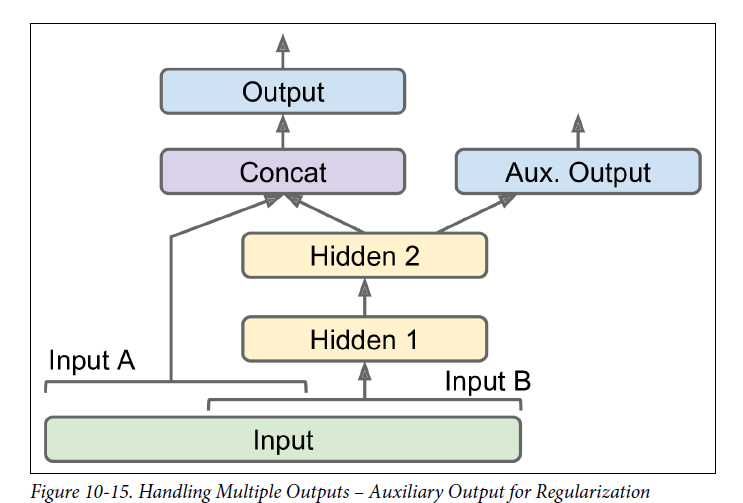

In [58]:
from PIL import Image
img =Image.open("../img/HandlingMultipleOutputs_AuxiliaryOutputforRegularization.png")
img

# Refer to page 308 of Hands-on Machine Learning with Scikit-Learn, Keras, 
# and TensorFlow Concepts, Tools, 
# and Techniques to Build Intelligent Systems by Aurélien Géron 
# June 2019: Second Edition

In [59]:
class MyModel(tf.keras.layers.Layer):
# class MyModel(tf.keras.Model):
    def __init__(self,embedding_matrix):
        super(MyModel, self).__init__()
        # Creating the layer instance attributes
        self.embedding = Embedding(vocab_length,w2v_vector_size,weights=[embedding_matrix],
                                        input_length=max_len,trainable=False)
        self.hidden1 = Bidirectional(LSTM(128,return_sequences=True),name="hidden1")
        self.hidden2 = Bidirectional(LSTM(128),name="hidden2")
        


    def call(self,input_tensor,training=False):
        embedding_layer = self.embedding(input_tensor)
        x = self.hidden1(embedding_layer)
        x = self.hidden2(x)
        return x

    def build_graph(self, raw_shape):
        x = tf.keras.layers.Input(shape=(raw_shape), 
                                         ragged=True)

        return tf.keras.Model(inputs=[x], 
                              outputs=self.call(x))

In [60]:
input_a = Input(shape=(100,), name="supply1")
input_b = Input(shape=(200,), name="supply2")

x = MyModel(embedding_matrix)(input_a)
contact= Concatenate()([input_b,x])
# from contact
output = Dense(3, name='Output_layer',activation="softmax")(contact)
# from hidden2
aux_output = Dense(3, name='Aux_output_layer',activation="softmax")(x)
model = Model(inputs=[input_a,input_b], outputs=[output,aux_output])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 supply1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 supply2 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 my_model_4 (MyModel)           (None, 256)          2182936     ['supply1[0][0]']                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 456)          0           ['supply2[0][0]',                
                                                                  'my_model_4[0][0]']       

In [61]:
# # How Training and Evaluation is done for this method

# bi_lstm_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])


# # Model training
# bi_lstm_model_history = bi_lstm_model.fit(
#     (X_train_A,X_train_B),(y_train,y_train),batch_size=128,epochs=10, verbose=1, validation_split=.2
# )

# # Predictions on the Test Set
# score = bi_lstm_model.evaluate((X_test_A,X_test_B), (y_test,y_test), verbose=1)

### **Classification report for each method**

The below classification report approach applies to the following; 
- Basic Functional; Same as sequential approach
- Wide and Deep Neural network
- Residual Block

In [62]:
# # Classification report test data
# from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
# y_true=np.argmax(y_test, axis=1)
# y_pred_test = bi_lstm_model.predict(X_test)
# y_pred_test=np.argmax(y_pred_test, axis=1)
# sns.set_theme(style='white')
# def class_report(model,y_true,pred):
#     print(classification_report(y_true,pred))
#     cm = confusion_matrix(y_true,pred,labels=[0,1,2])
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
#     disp.plot()
#     plt.show()


# class_report(bi_lstm_model,y_true,y_pred_test) 

# # Original mapping
# # sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# # New mapping
# # negative --> 0
# # neutral --> 1
# # positive --> 2

Handling Multiple Inputs

In [63]:
# # Classification report test data
# from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
# y_true=np.argmax(y_test, axis=1)
# y_pred_test = bi_lstm_model.predict((X_test_A,X_test_B)) # Handling multiple inputs
# y_pred_test=np.argmax(y_pred_test, axis=1)
# sns.set_theme(style='white')
# def class_report(model,y_true,pred):
#     print(classification_report(y_true,pred))
#     cm = confusion_matrix(y_true,pred,labels=[0,1,2])
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
#     disp.plot()
#     plt.show()


# class_report(bi_lstm_model,y_true,y_pred_test) 

# # Original mapping
# # sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# # New mapping
# # negative --> 0
# # neutral --> 1
# # positive --> 2

Handling Multiple Outputs- Auxiliary Output for Regularization

In [64]:
# # Classification report test data
# from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
# y_true=np.argmax(y_test, axis=1)
# y_pred_main, y_pred_aux = bi_lstm_model.predict((X_test_A,X_test_B))

# y_pred_main=np.argmax(y_pred_main, axis=1)
# y_pred_aux=np.argmax(y_pred_aux, axis=1)
# sns.set_theme(style='white')
# def class_report(model,y_true,pred):
#     print(classification_report(y_true,pred))
#     cm = confusion_matrix(y_true,pred,labels=[0,1,2])
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
#     disp.plot()
#     plt.show()


# class_report(bi_lstm_model,y_true,y_pred_main) 
# class_report(bi_lstm_model,y_true,y_pred_aux) 

# # Original mapping
# # sentiment_mapping = {'negative':-1,'neutral':0,'positive':1}

# # New mapping
# # negative --> 0
# # neutral --> 1
# # positive --> 2